Backward propagation for layer $l$ \
$dZ^{[l]}=dA^{[l]}*g^{[l]}´(Z^{[l]})$ \
$dW^{[l]}=\frac{1}{m}dZ^{[l]}A^{[l-1]T}$ \
$db^{[l]} = \frac{1}{m}np.sum(dZ^{[l]}, axis=1, keepdims=True)$ \
$dA^{[l-1]} = W^{[l]T}dZ^{[l]}$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import tqdm
import os
import cv2

In [ ]:
def sigmoid(z):
  return 1/(1 + np.exp(-z)), z

In [ ]:
def sigmoid1(z):
  return 1/(1 + np.exp(-z))

In [ ]:
def relu(z):
  f = np.maximum(0, z)
  return f, z

In [ ]:
def initialize_parameters_deep(layer_dims):
  parameters = {}
  L = len(layer_dims)
  for l in range(1, L):
    parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])
    parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
  return parameters

In [ ]:
def linear_forward(A, W, b):
  Z = np.dot(W, A) + b
  cache = (A, W, b)
  return Z, cache

In [ ]:
def linear_activation_forward(A_prev, W, b, activation):
  if activation == "sigmoid":
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = sigmoid(Z)
  elif activation == "relu":
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = relu(Z)
  cache = (linear_cache, activation_cache)
  return A, cache


In [ ]:
def L_model_forward(X, parameters):
  caches = []
  A = X
  L = len(parameters) // 2
  for l in range(1, L):
    A_prev = A
    A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
    caches.append(cache)
  AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
  caches.append(cache)
  return AL, caches

In [ ]:
def compute_cost(AL, Y):
  m = Y.shape[1]
  cost = -np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1-Y, np.log(1-AL)))/m
  cost = np.squeeze(cost)
  return cost

In [ ]:
def linear_backward(dZ, cache):
  A_prev, W, b = cache
  m = A_prev.shape[1]
  dW = np.dot(dZ, A_prev.T)/m
  db = np.sum(dZ, axis = 1, keepdims = True)/m
  dA_prev = np.dot(W.T, dZ)
  return dA_prev, dW, db

In [ ]:
def linear_activation_backward(dA, cache, activation):
  linear_cache, activation_cache = cache
  if activation == "relu":
    g_prima = np.where(activation_cache > 0, 1, 0)
    dZ = np.multiply(dA, g_prima)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
  elif activation == "sigmoid":
    g_prima = np.multiply(sigmoid1(activation_cache), 1 - sigmoid1(activation_cache))
    dZ = np.multiply(dA, g_prima)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
  return dA_prev, dW, db

In [ ]:
def L_model_backward(AL, Y, caches):
  grads = {}
  L = len(caches)
  m = AL.shape[1]
  Y = Y.reshape(AL.shape)
  dAL = - (np.divide(Y, AL) - np.divide(1-Y, 1-AL))
  current_cache = caches[L-1]
  dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
  grads["dA" + str(L-1)] = dA_prev_temp
  grads["dW" + str(L)] = dW_temp
  grads["db" + str(L)] = db_temp
  for l in reversed(range(L-1)):
    current_cache = caches[l]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
    grads["dA" + str(l)] = dA_prev_temp
    grads["dW" + str(l+1)] = dW_temp
    grads["db" + str(l+1)] = db_temp
  return grads

In [ ]:
def update_parameters(params, grads, learning_rate):
  parameters = copy.deepcopy(params)
  L = len(parameters) // 2
  for l in range(L):
    parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
    parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
  return parameters

In [ ]:
def L_layer_model(X, Y, layer_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
  np.random.seed(1)
  costs = []
  parameters = initialize_parameters_deep(layer_dims)
  for i in tqdm.tqdm(range(0, num_iterations)):
    AL, caches = L_model_forward(X, parameters)
    cost = compute_cost(AL, Y)
    grads = L_model_backward(AL, Y, caches)
    parameters = update_parameters(parameters, grads, learning_rate)
    if print_cost and (i % 100 ==  0 or i == num_iterations - 1):
      print(f"Cost after iteration {i} : {np.squeeze(cost)}")
    if i % 100 == 0:
      costs.append(cost)
  return parameters, costs

In [ ]:
def model_predict(X, parameters):
  AL, caches = L_model_forward(X, parameters)
  predictions = np.where(AL > 0.5, 1, 0)
  predictions = predictions.reshape(1, -1)
  return predictions

## Aquí comienza la aplicación en una dataset concreto

In [ ]:
def extract_images(dimension, *args):
  """
  Recorre varias carpetas con imagenes del mismo tipo en cada una de ellas.

  Parameters
  ----------
  dimension : array-like
    Contiene los valores del tamaño que se desea en cada una de las imagenes.
  **args
    Se especifica la ruta de cada una de las carpetas con las imagenes.

  Returns
  -------
  salida : tupla
    tupla con el data set de imagenes, el vector de etiquetas y el número de datos para cada tipo
  """
  images = []
  Y = []
  size = []
  for i in tqdm.tqdm(range(len(args))):
    contador = 0
    for image in os.listdir(args[i]):
      path = os.path.join(args[i], image)
      img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      if img is None:
        continue
      img = cv2.resize(img, dimension)
      images.append(img)
      Y.append(i)
      contador += 1
    size.append(contador)
  images = np.array(images)
  Y = np.array(Y).reshape(-1, len(Y))
  return images, Y, size




In [ ]:
andres_path = "/content/dataset/andres"
claudia_path = "/content/dataset/claudia"

In [ ]:
images, Y, size = extract_images((100, 100), andres_path, claudia_path)

100%|██████████| 2/2 [00:00<00:00, 18.91it/s]


In [ ]:
images.shape

(59, 100, 100)

La imagen de arriba tienen la etiqueta: [0]


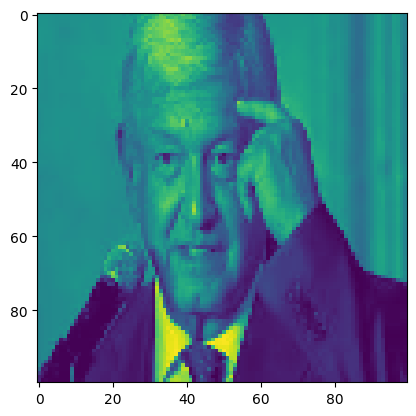

In [ ]:
plt.imshow(images[2])
print("La imagen de arriba tienen la etiqueta: " + str(Y[:, 2]))

la imagen de arriba tiene la etiqueta: [1]


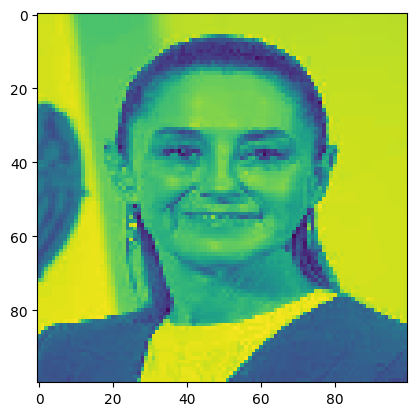

In [ ]:
plt.imshow(images[35])
print("la imagen de arriba tiene la etiqueta: " + str(Y[:, 35]))

In [ ]:
X = images.reshape(images.shape[0], -1).T
X.shape

(10000, 59)

In [ ]:
X = np.divide(X, 255)

In [ ]:
parameters, costs = L_layer_model(X, Y, [10000, 7, 4, 3, 1], learning_rate = 0.0075, num_iterations = 3000, print_cost = True)

  1%|          | 23/3000 [00:00<00:13, 221.13it/s]

Cost after iteration 0 : 1.502570659286257


  5%|▍         | 137/3000 [00:00<00:12, 221.47it/s]

Cost after iteration 100 : 0.6476322720410929


  8%|▊         | 229/3000 [00:01<00:12, 214.79it/s]

Cost after iteration 200 : 0.6251490714211047


 12%|█▏        | 345/3000 [00:01<00:11, 228.73it/s]

Cost after iteration 300 : 0.6012321880931419


 15%|█▍        | 436/3000 [00:02<00:12, 208.87it/s]

Cost after iteration 400 : 0.5453037543312607


 18%|█▊        | 527/3000 [00:02<00:11, 219.89it/s]

Cost after iteration 500 : 0.5193314041196233


 21%|██        | 620/3000 [00:02<00:10, 223.75it/s]

Cost after iteration 600 : 0.5085325344216458


 24%|██▍       | 735/3000 [00:03<00:10, 218.11it/s]

Cost after iteration 700 : 0.5022710549712407


 28%|██▊       | 826/3000 [00:03<00:09, 220.50it/s]

Cost after iteration 800 : 0.4976331653377216


 31%|███▏      | 942/3000 [00:04<00:09, 221.33it/s]

Cost after iteration 900 : 0.4947202609423987


 34%|███▍      | 1035/3000 [00:04<00:08, 226.27it/s]

Cost after iteration 1000 : 0.4925434879773733


 38%|███▊      | 1129/3000 [00:05<00:08, 209.54it/s]

Cost after iteration 1100 : 0.4908546365771175


 41%|████      | 1223/3000 [00:05<00:07, 223.09it/s]

Cost after iteration 1200 : 0.48952877068040734


 45%|████▍     | 1341/3000 [00:06<00:07, 210.80it/s]

Cost after iteration 1300 : 0.48855920161566063


 48%|████▊     | 1440/3000 [00:06<00:06, 237.01it/s]

Cost after iteration 1400 : 0.4877294948818911


 51%|█████▏    | 1541/3000 [00:07<00:05, 244.37it/s]

Cost after iteration 1500 : 0.4872615485476501


 55%|█████▍    | 1641/3000 [00:07<00:05, 229.59it/s]

Cost after iteration 1600 : 0.4866697289957336


 58%|█████▊    | 1740/3000 [00:07<00:05, 235.31it/s]

Cost after iteration 1700 : 0.4862689336321507


 61%|██████▏   | 1840/3000 [00:08<00:05, 227.20it/s]

Cost after iteration 1800 : 0.48589092547754414


 65%|██████▍   | 1938/3000 [00:08<00:04, 237.78it/s]

Cost after iteration 1900 : 0.4856266845031686


 68%|██████▊   | 2033/3000 [00:09<00:04, 225.55it/s]

Cost after iteration 2000 : 0.4854217432038752


 71%|███████   | 2128/3000 [00:09<00:03, 221.44it/s]

Cost after iteration 2100 : 0.4853638423035398


 73%|███████▎  | 2190/3000 [00:10<00:06, 128.13it/s]

Cost after iteration 2200 : 0.48502267140287575


 77%|███████▋  | 2314/3000 [00:12<00:07, 91.15it/s]

Cost after iteration 2300 : 0.48486301919852803


 81%|████████▏ | 2443/3000 [00:13<00:02, 205.37it/s]

Cost after iteration 2400 : 0.4847084753384416


 84%|████████▍ | 2531/3000 [00:13<00:02, 207.34it/s]

Cost after iteration 2500 : 0.4845951672633404


 88%|████████▊ | 2645/3000 [00:14<00:01, 221.01it/s]

Cost after iteration 2600 : 0.48446229735212015


 91%|█████████ | 2732/3000 [00:14<00:01, 190.16it/s]

Cost after iteration 2700 : 0.48436293248868134


 95%|█████████▍| 2845/3000 [00:15<00:00, 216.90it/s]

Cost after iteration 2800 : 0.4842359967304254


 98%|█████████▊| 2931/3000 [00:15<00:00, 198.19it/s]

Cost after iteration 2900 : 0.4841717441033349


100%|██████████| 3000/3000 [00:16<00:00, 185.06it/s]

Cost after iteration 2999 : 0.4840327720459862


In [ ]:
Y_hat = model_predict(X, parameters)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(Y.T, Y_hat.T)

0.7457627118644068